# 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# 2

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46035032.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1745697.48it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13863752.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10892240.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# 3

In [ ]:
class NetStandard(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NetStandard, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc3(x)
        return x

class NetGrowth(nn.Module):
    def __init__(self, dropout_start=0.1, dropout_end=0.5, total_epochs=50):
        super(NetDecay, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.dropout_start = dropout_start
        self.dropout_end = dropout_end
        self.total_epochs = total_epochs

    def forward(self, x, epoch):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dynamic_dropout(x, epoch)
        x = F.relu(self.fc2(x))
        x = self.dynamic_dropout(x, epoch)
        x = self.fc3(x)
        return x

    def dynamic_dropout(self, x, epoch):
        p = self.get_dropout_rate(epoch)
        return F.dropout(x, p=p, training=self.training)

    def get_dropout_rate(self, epoch):
        return self.dropout_start + (self.dropout_end - self.dropout_start) * (epoch / self.total_epochs)


# 4

In [ ]:
def train_and_record_errors(net, trainloader, testloader, criterion, optimizer, num_epochs=50, decay=False):
    net.to(device)
    train_errors = []
    test_errors = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if decay:
                outputs = net(inputs, epoch)
            else:
                outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate train and test error
        train_error = calculate_classification_error(net, trainloader, epoch, decay)
        test_error = calculate_classification_error(net, testloader, epoch, decay)

        train_errors.append(train_error)
        test_errors.append(test_error)

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Error: {train_error}, Test Error: {test_error}')

    return train_errors, test_errors

def calculate_classification_error(net, dataloader, epoch, decay):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            if decay:
                outputs = net(images, epoch)
            else:
                outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    error = 1 - (correct / total)
    return error


# 5

In [ ]:
# Instantiate and train the models
net_standard = NetStandard(dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(net_standard.parameters(), lr=0.001, momentum=0.9)
train_errors_standard, test_errors_standard = train_and_record_errors(net_standard, trainloader, testloader, criterion, optimizer_standard, num_epochs=10, growth=False)

net_growth = NetGrowth(dropout_start=0.1, dropout_end=0.5, total_epochs=10).to(device)
optimizer_growth = optim.SGD(net_growth.parameters(), lr=0.001, momentum=0.9)
train_errors_growth, test_errors_growth = train_and_record_errors(net_growth, trainloader, testloader, criterion, optimizer_growth, num_epochs=10, growth=True)


TypeError: train_and_record_errors() got an unexpected keyword argument 'growth'

# 6

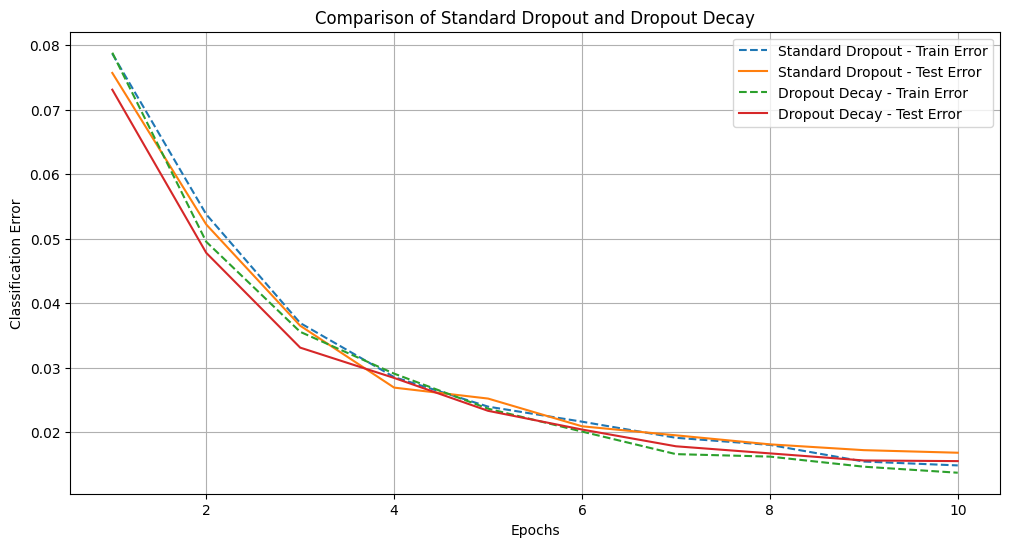

In [ ]:
epochs = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_errors_standard, label='Standard Dropout - Train Error', linestyle='--')
plt.plot(epochs, test_errors_standard, label='Standard Dropout - Test Error')
plt.plot(epochs, train_errors_growth, label='Dropout Decay - Train Error', linestyle='--')
plt.plot(epochs, test_errors_growth, label='Dropout Decay - Test Error')

plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Dropout Decay')
plt.legend()
plt.grid(True)
plt.show()
